# DEEPMIND ALPHAZERO CHESS

## TODO
- print("ADDITIONAL LEGAL ACTIONS", set(legal_actions).difference(agent_actions)), Agent actions Legal actions mismatch
- Counts are zero when simulation ends but it doesnt end
- BIG PROBLEM.. Within MCTS, white plays blacks move and black plays whites moves!!!! Causes counts fail and maybe cause of invalid legal action


## TODO LATER
- Create controller (MDN-LSTM should be trainable)
- Link Controller - Monte Carlo Tree Search 
- Create Self play class
- Create Arena class

DEEP MIND OPEN ACCESS PAPER 

https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd

DUPLICATED MCTS IMPLEMENTATION

https://github.com/suragnair/alpha-zero-general/blob/master/MCTS.py

DISTRIBUTED IMPLEMENTATION

https://github.com/mokemokechicken/reversi-alpha-zero/blob/master/src/reversi_zero/lib/ggf.py

CHESS MOVES

https://www.ichess.net/blog/chess-pieces-moves/

BOARD REPRESENTATIONS

https://medium.com/datadriveninvestor/reconstructing-chess-positions-f195fd5944e

ALPHA ZERO EXPLANATION

https://nikcheerla.github.io/deeplearningschool/2018/01/01/AlphaZero-Explained/

TRANSFORMER NETWORK IMPLEMENTATION

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [1]:
import chess, gym, pickle, random, torch, math
import chess.svg as svg
import numpy as np
import pandas as pd
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import torch.optim as optim
# plt.style.use('ggplot')
from scipy.ndimage.interpolation import shift
from copy import deepcopy
from colorama import init, Fore, Back, Style
from collections import Counter

from utilities import *
# import constants 
from constants import *
from models.vae import CNN_VAE, train_vae
from models.mdn import MDN_RNN, loss_function, clip_grad_norm_

# init(convert = True)
# REFERENCES
# Tensorflow implementation for Chess
# https://github.com/saurabhk7/chess-alpha-zero

# Pytorch implementation for Connect4
# https://github.com/plkmo/AlphaZero_Connect4/tree/master/src

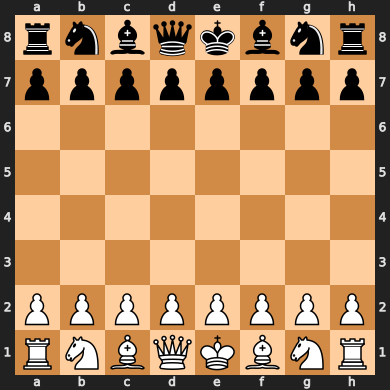

In [50]:
class Chess_Environment(gym.Env):
    """Chess Environment"""
    def __init__(self):
        self.board = chess.Board()
        self.white_pieces = ['P', 'N', 'B', 'R', 'Q', 'K']
        self.black_pieces = [piece.lower() for piece in self.white_pieces]
        self.x_coords, self.y_coords = np.meshgrid(list(range(0, 8)), list(range(0, 8)))
        self.x_coords = self.x_coords / 7
        self.y_coords = self.y_coords / 7
        self.state_size = self.observe()[0].shape
        self.init_action_decoder()
        self.whites_turn = True

    def reset(self):
        """Resets the environment"""
        self.board = chess.Board()
        
    def terminal_test(self):
        """Checks if the game is over"""
        return self.board.is_game_over(claim_draw = True)
    
    def result(self):
        """Gives the end game result"""

        result = self.board.result(claim_draw = True)
        if result == '1-0':
            return 1
        elif result == '0-1':
            return -1
        elif result == '1/2-1/2':
            return 0.5
        elif result == '*':
            return 0
        else:
            raise Exception('Invalid Result', result)
        
    def legal_actions(self):
        """Provides a list of legal actions in current state"""
        legal_actions = [str(legal_action) for legal_action in list(self.board.legal_moves)]
        return legal_actions
    
    def encode(self):
        """Encodes game state into a string"""
        board_ = self.board.piece_map()
            
        encoded = {
            'board' : board_,
            'turn' : self.board.turn,
            'legal_actions' : self.legal_actions()
        }
        
        return pickle.dumps(encoded)
    
    def decode(self, encoded):
        """Decodes string into game state and sets board and turn"""
        decoded = pickle.loads(encoded)
        self.board.set_piece_map(decoded['board'])
        if decoded['turn'] == False:
            self.board = self.board.mirror()
        self.board.turn = decoded['turn']

    def observe(self):
        """Create observation from the game state"""

        board_ = copy(self.board)
            
        board_ = np.ndarray.flatten(np.array(board_.__str__().split())).reshape(8, 8)
        
        black_pawns = np.isin(copy(board_), ['p']).astype(int)
        black_knights = np.isin(copy(board_), ['n']).astype(int)
        black_rooks = np.isin(copy(board_), ['r']).astype(int)
        black_bishops = np.isin(copy(board_), ['b']).astype(int)
        black_queen = np.isin(copy(board_), ['q']).astype(int)
        black_king = np.isin(copy(board_), ['k']).astype(int)
         
        white_pawns = np.isin(copy(board_), ['P']).astype(int)
        white_knights = np.isin(copy(board_), ['N']).astype(int)
        white_rooks = np.isin(copy(board_), ['R']).astype(int)
        white_bishops = np.isin(copy(board_), ['B']).astype(int)
        white_queen = np.isin(copy(board_), ['Q']).astype(int)
        white_king = np.isin(copy(board_), ['K']).astype(int)
        
        state = np.array([
            white_pawns,
            white_knights,
            white_rooks,
            white_bishops,
            white_queen,
            white_king,
            black_pawns,
            black_knights,
            black_rooks,
            black_bishops,
            black_queen,
            black_king
        ])
        
        return state, self.legal_actions()
    
    def step(self, action):
        """Perform a step in the environment"""
        self.board.push_uci(action)
        self.board = self.board.mirror()
        if self.whites_turn:
            self.whites_turn = False
        else:
            self.whites_turn = True
        return self.observe()
    
    def move_board(self, move):
        """Moves the board positions as per the move"""

        char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

        int_to_char = {v: k for k, v in char_to_int.items()}

        encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(BOARD)]

        new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(BOARD)]
        moves = []
        for pos, new_pos in zip(np.ndarray.flatten(BOARD), new_board):
            try:
                if new_pos[1] > 8:
                    raise Exception()
                if move[2] is None:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
                else:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
                if '-' in move_:
                    raise Exception()
            
                if '0' in move_:
                    raise Exception()
                
            except Exception:
                move_ = 'XXXX'
            moves.append(move_)   
        return np.array(moves).reshape(8, 8)
    
    def init_action_decoder(self):
        """Initialize the decoder to decode the actions"""
        decoder = []
        for key in MOVES.keys():
            decoder_ = self.move_board(MOVES[key])
            decoder.append(decoder_)
#             print(f'Move {key}\n', new_board, '\n')
    
        self.decoder = np.array(decoder)
        self.action_size = self.decoder.shape
        
    def select_action(self, logits):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in self.legal_actions()}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))

        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        return action
    
    def render(self):
        """Render chess board"""
        chess.svg.board(board = self.board)  

env = Chess_Environment()
env.board

In [40]:
class Agent:
    
    def __init__(self, decoder, action_size):
        self.action_size = action_size
        self.decoder = decoder
        
        self.char_to_int = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8} 
        self.char_to_int_promo = {'r': 1, 'b': 2, 'q': 3, 'k': 4, 'n': 5, '': 6} 
        
        moves_df = pd.DataFrame(list(zip(self.char_to_int.values(), self.char_to_int.keys())), columns = ['Ids', 'Labels'])
        promo_df = pd.DataFrame(list(zip(self.char_to_int_promo.values(), self.char_to_int_promo.keys())), columns = ['Ids', 'Labels'])
        self.move_actions_ohe = pd.get_dummies(moves_df['Ids'])
        self.promo_actions_ohe = pd.get_dummies(promo_df['Ids'])
    
    def select_action(self, logits, legal_actions):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))
        
        legal_actions = list(legal_move_logits.keys())
        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        
        action_probabilities = {legal_actions[idx] : probabilities[idx] for idx in range(len(legal_actions))}
        return action, action_probabilities
    
    def one_hot_encode_action(self, action):
        """One hot encodes the action"""
        if len(action) == 4:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[''] - 1].values
            ]
        else:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[action[4]] - 1].values
            ]
        ohe_action = np.concatenate(encoded_action)
        return ohe_action
    
    def act(self, state, legal_actions):
        """Gets an action from the agent"""
        logits = np.random.rand(env.action_size[0], env.action_size[1], env.action_size[2])
        action, probabilities, legal_actions = self.select_action(logits, legal_actions)
        probabilities
        return action
    
    def mcts_act(self, state, legal_actions):
        """Gets an action from the agent"""
        logits = np.random.rand(env.action_size[0], env.action_size[1], env.action_size[2])
        action, action_probabilities = self.select_action(logits, legal_actions)
        
        return action_probabilities, np.random.rand(10)[0]
    
    
agent = Agent(env.decoder, env.action_size)

#### Encode State

In [41]:
# state, legal_actions = env.observe()

# state_planes = [
#     'White Pawns',
#     'White Knights',
#     'White Rooks',
#     'White Bishops',
#     'White Queen',
#     'White King',
#     'Black Pawns',
#     'Black Knights',
#     'Black Rooks',
#     'Black Bishops',
#     'Black Queen',
#     'Black King'
# ]

# for inx, state_ in enumerate(state):
#     fig = plt.figure()
#     fig.suptitle(state_planes[inx], fontsize = 20)
#     xticks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
#     yticks = list(range(1, 9))
#     yticks.reverse()
#     plt.xticks(list(range(0, 8)), xticks)
#     plt.yticks(list(range(0, 8)), yticks)
#     plt.imshow(state_)


#### Encode Actions

In [42]:
# queen_directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
# queen_distance = list(range(1, 8))
# queen_moves = [f'{direction}{distance}' for direction in queen_directions for distance in queen_distance]

# knight_moves = ['2N1E', '1N2E', '1S2E', '2S1E', '2S1W', '1S2W', '1N2W', '2N1W']
# underpromotion_moves = ['DOUBLEM', 'NECUT', 'NWCUT']
# moves = queen_moves + knight_moves + underpromotion_moves

# print(f'{len(queen_moves)} QUEEN MOVES {queen_moves[: 15]}\n{len(knight_moves)} KNIGHT MOVES {knight_moves}\n{len(underpromotion_moves)} UNDERPROMOTION MOVES {underpromotion_moves}')
# print(f'\nTOTAL MOVES {len(moves)}')
# print(moves)

#### Encode Actions

In [43]:
# def move_board(move):
#     """Moves the board positions as per the move"""
#     print(move)
#     board = np.array([
#         ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8'],
#         ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7'],
#         ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6'],
#         ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5'],
#         ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4'],
#         ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3'],
#         ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'],
#         ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1']
#     ])

#     char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

#     int_to_char = {v: k for k, v in char_to_int.items()}

#     encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(board)]

#     new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(board)]
 
#     moves = []
#     for pos, new_pos in zip(np.ndarray.flatten(board), new_board):
#         try:
# #             print(pos, new_pos)
#             if new_pos[1] > 8:
#                 raise Exception()
            
#             if move[2] is None:
#                 move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
#             else:
#                 move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
#             if '-' in move_:
#                 raise Exception()
            
#             if '0' in move_:
#                 raise Exception()
                
#         except Exception:
#             move_ = 'XXXX'
#         moves.append(move_)
#     return np.array(moves).reshape(8, 8)

# moves = {
#     # Queen Moves
#     'Q N1': (0, 1, None),
#     'Q N2': (0, 2, None),
#     'Q N3': (0, 3, None),
#     'Q N4': (0, 4, None),
#     'Q N5': (0, 5, None),
#     'Q N6': (0, 6, None),
#     'Q N7': (0, 7, None),
#     'Q NE1': (1, 1, None),
#     'Q NE2': (2, 2, None),
#     'Q NE3': (3, 3, None),
#     'Q NE4': (4, 4, None),
#     'Q NE5': (5, 5, None),
#     'Q NE6': (6, 6, None),
#     'Q NE7': (7, 7, None),
#     'Q E1': (1, 0, None),
#     'Q E2': (2, 0, None),
#     'Q E3': (3, 0, None),
#     'Q E4': (4, 0, None),
#     'Q E5': (5, 0, None),
#     'Q E6': (6, 0, None),
#     'Q E7': (7, 0, None),
#     'Q SE1': (1, -1, None),
#     'Q SE2': (2, -2, None),
#     'Q SE3': (3, -3, None),
#     'Q SE4': (4, -4, None),
#     'Q SE5': (5, -5, None),
#     'Q SE6': (6, -6, None),
#     'Q SE7': (7, -7, None),
#     'Q S1': (0, -1, None),
#     'Q S2': (0, -2, None),
#     'Q S3': (0, -3, None),
#     'Q S4': (0, -4, None),
#     'Q S5': (0, -5, None),
#     'Q S6': (0, -6, None),
#     'Q S7': (0, -7, None),
#     'Q SW1': (-1, -1, None),
#     'Q SW2': (-2, -2, None),
#     'Q SW3': (-3, -3, None),
#     'Q SW4': (-4, -4, None),
#     'Q SW5': (-5, -5, None),
#     'Q SW6': (-6, -6, None),
#     'Q SW7': (-7, -7, None),
#     'Q W1': (-1, 0, None),
#     'Q W2': (-2, 0, None),
#     'Q W3': (-3, 0, None),
#     'Q W4': (-4, 0, None),
#     'Q W5': (-5, 0, None),
#     'Q W6': (-6, 0, None),
#     'Q W7': (-7, 0, None),
#     'Q NW1': (-1, 1, None),
#     'Q NW2': (-2, 2, None),
#     'Q NW3': (-3, 3, None),
#     'Q NW4': (-4, 4, None),
#     'Q NW5': (-5, 5, None),
#     'Q NW6': (-6, 6, None),
#     'Q NW7': (-7, 7, None),
#     # Knight Moves
#     '2N1E' : (1, 2, None),
#     '1N2E' : (2, 1, None),
#     '1S2E' : (2, -1, None),
#     '2S1E' : (1, -2, None),
#     '2S1W' : (-1, -2, None),
#     '1S2W' : (-2, -1, None),
#     '1N2W' : (-2, 1, None),
#     '2N1W' : (-1, 2, None),
#     # Promtions
#     'PQ N1' : (0, 1, 'q'),
#     'PR N1' : (0, 1, 'r'),
#     'PB N1' : (0, 1, 'b'),
#     'PN N1' : (0, 1, 'n'),
#     'PQ NE1' : (1, 1, 'q'),
#     'PR NE1' : (1, 1, 'r'),
#     'PB NE1' : (1, 1, 'b'),
#     'PN NE1' : (1, 1, 'n'),
#     'PQ NW1' : (-1, 1, 'q'),
#     'PR NW1' : (-1, 1, 'r'),
#     'PB NW1' : (-1, 1, 'b'),
#     'PN NW1' : (-1, 1, 'n')
# }

# new_boards = []
# for key in moves.keys():
#     print(f'Move {key}')
#     new_board = move_board(moves[key])
#     new_boards.append(new_board)
#     print(new_board, '\n')
    
# new_boards = np.array(new_boards)
# new_boards.shape

#### Decode Actions

In [44]:
# # logits = env.action
# # np.random.rand(len(moves), 8, 8)

# print(env.action_size)
# new_boards_ = np.ndarray.flatten(new_boards)
# logits_ = np.ndarray.flatten(logits)

# move_logits = [(new_boards_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
# move_logits = dict(move_logits)

# legal_actions = ['g1h3','g1f3','b1c3','b1a3','h2h3','g2g3','f2f3','e2e3','d2d3','c2c3','b2b3','a2a3','h2h4','g2g4','f2f4','e2e4','d2d4','c2c4','b2b4','a2a4']

# legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
# legal_move_logits

#### Create Training Data for VAE and figure out action size

In [45]:
# def create_vae_training_data(games):
#     """Creates training date for CNN-VAE"""
#     actions = {}
#     states = {}
#     for game in range(1, games + 1):
#         env.reset()
#         state, legal_actions = env.observe()
#         encoded_state = env.encode()
#         states[encoded_state] = state
#         while not env.terminal_test():
#             action = random.choice(legal_actions)            
#             state, legal_actions = env.step(action)
#             encoded_state = env.encode()
#             states[encoded_state] = state
# #             actions[encoded_state] = agent.one_hot_encode_action(action)
#         print(f'Game {game} | Unique States {len(states.keys())} Unique Actions {len(actions)}', end = '\r')
    
#     validate_path('data/vae')
#     with open('data/vae/states.pkl', 'wb') as file:
#         pickle.dump(states, file)
#     with open('data/vae/actions.pkl', 'wb') as file:
#         pickle.dump(actions, file)
    
# create_vae_training_data(100)

#### Train VAE

In [46]:
# def train_vae_(name, starting_channels, filename, z_size, epochs, batch_size):
#     """Trains the CNN-VAE"""
#     params = {
#         'z_size' : z_size,
#         'batch_size' : batch_size,
#         'learning_rate' : 1e-4,
#         'kl_tolerance' : 0.5,
#         'batch_norm' : False,
#         'starting_channels' : starting_channels
#     }

#     vae = CNN_VAE(name, params, False)
#     with open(f'data/vae/{filename}',  'rb') as pickle_file:
#         data = list(pickle.load(pickle_file).values())
#         data = [np.array(data_) for data_ in data]
    
#     train_vae(vae, data, epochs, 100)

    
# train_vae_('Test States', env.state_size[0], 'states.pkl', 600, 100, 200)
# # train_vae_('Test Actions', env.action_size[0], 'actions.pkl', 600, 100, 200)

#### Create Training Data for MDN

In [47]:
# def create_mdn_training_data(name, games):
#     """Create training data for MDN-RNN"""
#     vae = CNN_VAE(name, None, 'Latest')
#     vae.eval()
#     data = pd.DataFrame(columns = ['Game ID', 'Sequence #', 'State ID'])
#     rollouts = []
#     transitions = 0
    
#     for game in range(1, games + 1):
#         states = []
#         actions = []
#         env.reset()
        
#         state, legal_actions = env.observe()
#         while not env.terminal_test():
#             action = random.choice(legal_actions)
#             states.append(state)
#             actions.append(agent.one_hot_encode_action(action))
#             state, legal_actions = env.step(action)
#             transitions += 1
            
#         mus, logvars = vae.encode(torch.tensor(states).float())
#         zs = vae.reparameterize(mus, logvars)
#         mus, logvars, zs = mus.squeeze(-1), logvars.squeeze(-1), zs.squeeze(-1)
#         actions = torch.tensor(actions).float().squeeze(-1)
#         zas = torch.cat([zs, actions], dim = 1)
#         rollouts.append((zs.detach().numpy(), actions.detach().numpy()))
        
#         print(f'Game {game} Transitions {transitions}', end = '\r')
    
#     validate_path('data/mdn')
#     with open('data/mdn/rollouts.pkl', 'wb') as file:
#         pickle.dump(rollouts, file)
    
    
# create_mdn_training_data('Test', 600)

In [48]:
# def training_mdn(vae_name, name):
#     torch.cuda.empty_cache() 
#     """Trains the MDN-RNN"""
#     epochs = 499
#     batch_size = 5
    
#     params = {
#         'hidden_size' : 100,
#         'gaussian_size' : 20,
#         'stacked_layers': 1,
#         'grad_clip' : 0.5,
#         'learning_rate' : 1e-4
#     }
    
#     with open(f'data/mdn/rollouts.pkl', 'rb') as pickle_file:
#         rollouts = pickle.load(pickle_file)
    
#     params['z_size'] = rollouts[0][0].shape[1]
#     params['action_size'] = rollouts[0][1].shape[1]
#     params['batch_size'] = batch_size
    
#     mdn = MDN_RNN(name, params, False)
    
#     mdn.train()
#     mdn = mdn.to(mdn.device)
#     optimizer = optim.Adam(mdn.parameters(), lr = mdn.learning_rate)
        
#     inputs = []
#     targets = []
#     seq_lengths = []
    
#     for rollout in rollouts:
#         zs, actions = rollout
#         zas = np.concatenate((zs, actions), axis = 1)
#         seq_lengths.append(zas.shape[0])
#         inputs.append(zas)
#         targets.append(zs)
        
#     idxs = range(len(rollouts))
    
#     # Sorts order from longest to shortest sequence
#     idxs = [x for _, x in sorted(zip(seq_lengths, idxs), reverse = True)]
#     seq_lengths = [seq_lengths[x] for x in idxs]
#     inputs = [np.array(inputs[x]) for x in idxs]
#     targets = [np.array(targets[x]) for x in idxs]
    
#     max_seq_len = max(seq_lengths)
#     rollout_size = len(seq_lengths)
    
#     padded_X = np.zeros((rollout_size, max_seq_len, inputs[0].shape[-1]))
#     padded_Y = np.zeros((rollout_size, max_seq_len, targets[0].shape[-1]))
# #     https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
    
#     for i, x_len in enumerate(seq_lengths):
#         padded_X[i, 0 : x_len] = inputs[i]
#         padded_Y[i, 0 : x_len] = targets[i]
        
#     inputs = torch.tensor(padded_X).float().squeeze(1).to(mdn.device)
#     targets = torch.tensor(padded_Y).float().squeeze(1).to(mdn.device)
    
#     if inputs.shape[0] % batch_size != 0:
#         inputs = inputs[inputs.shape[0] // batch_size, :, :]
        
#     inputs = inputs.reshape(-1, batch_size, max_seq_len, mdn.z_size + mdn.action_size)
#     targets = targets.reshape(-1, batch_size, max_seq_len, mdn.z_size)
#     seq_lengths = list(torch.tensor(seq_lengths).reshape(-1, batch_size).numpy())
    
#     for epoch in range(epochs + 1):
#         for batch in range(inputs.shape[0]):
#             inputs_ = inputs[batch]
#             targets_ = targets[batch]
#             seq_lengths_ = list(seq_lengths[batch])
            
#             targets_ = torch.nn.utils.rnn.pack_padded_sequence(targets_, seq_lengths_, batch_first = True)
#             targets_, _ = torch.nn.utils.rnn.pad_packed_sequence(targets_, batch_first = True)
            
#             # Set initial hidden and cell states
#             hidden = mdn.init_hidden(batch_size)

#             # Forward pass
#             hidden = (hidden[0].detach(), hidden[1].detach())
#             (pi, mu, sigma), hidden = mdn(inputs_, hidden, seq_lengths_)
#             loss = loss_function(targets_, pi, mu, sigma)

#             # Backward and optimize
#             mdn.zero_grad()
#             loss.backward()
#             clip_grad_norm_(mdn.parameters(), mdn.grad_clip)
#             optimizer.step()
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, loss.item()))
            
#     mdn.save_model()
# training_mdn('Test', 'Test')

# ALPHA GO TIPS 


## MCTS
Each simulation proceeds by
selecting in each state s a move a with low visit count, high move probability and high value
(averaged over the leaf states of simulations that selected a from s) according to the current
neural network fθ. The search returns a vector π representing a probability distribution over
moves, either proportionally or greedily with respect to the visit counts at the root state.
The parameters θ of the deep neural network in AlphaZero are trained by self-play reinforcement learning, starting from randomly initialised parameters θ. Games are played by selecting
moves for both players by MCTS, at ∼ πt
. At the end of the game, the terminal position sT is
scored according to the rules of the game to compute the game outcome z: −1 for a loss, 0 for
a draw, and +1 for a win. The neural network parameters θ are updated so as to minimise the
error between the predicted outcome vt and the game outcome z, and to maximise the similarity
of the policy vector pt
to the search probabilities πt
. Specifically, the parameters θ are adjusted
by gradient descent on a loss function l that sums over mean-squared error and cross-entropy
losses respectively

(p, v) = fθ(s)                    

l = (z − v) 2 − π > log p + c||θ||2


In [52]:
class MCTS():
    """Monte Carlo Tree Search Algorithm geared for Neural Networks"""

    def __init__(self, env, agent, mcts_simulations = 100, max_depth = 100, delta = 0.5):
        self.env = env
        self.agent = agent
        self.cpuct = 0.2    # WARNING BULLSHIT NUMBER!
        self.delta = delta  # value to prevent crash if no edges are visited
        self.mcts_simulations = mcts_simulations
        self.max_depth = max_depth
        
        self.Qsa = {}       # stores Q values for s, a (as defined in the paper)
        self.Nsa = {}       # stores # times edge s, a was visited
        self.Ns = {}        # stores # times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores victory result (1, 0, -1) ended for board s
        self.Vs = {}        # stores legal actions for board s

    def action_probabilities(self, encoded_state, temp = 1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        
        for runs in range(self.mcts_simulations):
            print(f"{Fore.BLUE}MCTS SIMULATION {runs + 1}{Style.RESET_ALL}")
            self.search(encoded_state, 0)
        
        s = encoded_state
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in legal_actions]
        # counts array represent the number of time each action edge from your current state was traversed

        if temp == 0: # temprature is 0 representing taking the best action possible (greedy)
            bestA = np.argmax(counts) # bestA: best action number : argmax Returns the indices of the maximum values
            probs = [0] * len(counts)
            probs[bestA] = 1
            action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
            return action_probs # returns the definite move(s) with same greedy reward, out of which one move HAS to be played
        
        print(f"{Fore.BLUE}COUNTS {sum(counts)} {counts}{Style.RESET_ALL}")
        
        # Handles frequent draw situation when MCTS fails to explore when the game is over resulting 0 counts causing div 0 error
        if sum(counts) == 0:
            counts = [1 for _ in counts]
            
        counts = [x ** (1. / temp) + 0.5 for x in counts]
        probs = [x / float(sum(counts)) for x in counts]
        action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
        return action_probs #returns the probablity of different moves that CAN be played resulting in uniform distribution


    def search(self, encoded_state, depth):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propogated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propogated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = deepcopy(encoded_state)
        self.env.decode(encoded_state)
        print(f"{Fore.GREEN}SEARCH DEPTH {depth}{Style.RESET_ALL}")
        
        # Check if its an terminal state, -1 Opponent Won, 0 Game not Over, 1 Player Won
        if s not in self.Es:
            self.Es[s] = self.env.result()
        if self.Es[s] != 0 or self.env.terminal_test():
            print("SIMULATION OVER!", self.env.terminal_test(), -self.Es[s], self.env.board.result())
            return -self.Es[s]
        
        legal_actions = self.env.legal_actions()

        if s not in self.Ps: #if the current state 's' is not explored/expanded before n=0 by MCTS then create a new node and rollout
            self.Ps[s], v = self.agent.mcts_act(encoded_state, legal_actions)
            valids = legal_actions

            self.Vs[s] = valids 
            self.Ns[s] = 0
            print("VALUE", -v)
            return -v
        
        valids = self.Vs[s] #as already visited the valid moves array 'Vs' is already initialized
        cur_best = -float('inf')
        best_act = -1
        
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        # pick the action with the highest upper confidence bound
        
        agent_actions = list(self.Ps[s].keys())
        
        # Handles the occasional legal action that isn't an actual legal action
        # Pawn side cut even though there is no enemy piece in respective position
        if not set(agent_actions) == set(legal_actions):
            legal_actions = agent_actions
            
        for a in legal_actions:
            if (s,a) in self.Qsa:
                u = self.Qsa[(s,a)] + self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (1 + self.Nsa[(s,a)])
            else:
                self.Ps[s][a] 
                u = self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s])     # Q = 0 ? : node exists but not explored as added and initilized during nnet phase
            if u > cur_best:
                cur_best = u
                best_act = a
        print(f"{Fore.GREEN}BEST ACTION {best_act}{Style.RESET_ALL}")
        a = best_act

        _, _ = self.env.step(a)
        encoded_next_state = self.env.encode()

        v = self.search(encoded_next_state, depth + 1) # RECURSION until leaf node or terminal node is found
        
        self.env.decode(encoded_state)
        
        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)] * self.Qsa[(s,a)] + v) / (self.Nsa[(s,a)] + 1) #update the Q Value
            self.Nsa[(s,a)] += 1 # increment number of visits to this node in MCTS
        else:
            self.Qsa[(s,a)] = v # initialize the new node
            self.Nsa[(s,a)] = 1

        self.Ns[s] += 1
        return -v

env.reset()
mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 2)
mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 2)
game_move = 0

while not env.terminal_test():
#     print(f"{Fore.RED}GAME MOVE {game_move}{Style.RESET_ALL}")
#     encoded_state = env.encode()
#     if env.whites_turn: 
#         action_probs = mcts_white.action_probabilities(encoded_state)
#     else:
#         action_probs = mcts_black.action_probabilities(encoded_state)
#     action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
#     print(f"{Fore.CYAN}ACTUAL MOVE\n {action_probs}{Style.RESET_ALL}")
#     _, _ = env.step(action)
    
#     game_move += 1
    try:
        print(f"{Fore.RED}GAME MOVE {game_move}{Style.RESET_ALL}")
        encoded_state = env.encode()
        if env.whites_turn: 
            action_probs = mcts_white.action_probabilities(encoded_state)
        else:
            action_probs = mcts_black.action_probabilities(encoded_state)
        action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
        print(f"{Fore.CYAN}ACTUAL MOVE\n {action_probs}{Style.RESET_ALL}")
        _, _ = env.step(action)
    
        game_move += 1
    except Exception as e:
        print(f'{Fore.RED}ERROR {e}{Style.RESET_ALL}')
        if env.whites_turn: 
            print(mcts_white.env.encode(), "\n", encoded_state)
        else:
            print(mcts_black.env.encode(), "\n", encoded_state)
        break
        
print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! GAME COMPLETED !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

GAME MOVE 0
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.07678910716734866
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION g1h3
SEARCH DEPTH 1
VALUE -0.6998766987397399
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'g1h3': 0.13636363636363635, 'g1f3': 0.045454545454545456, 'b1c3': 0.045454545454545456, 'b1a3': 0.045454545454545456, 'h2h3': 0.045454545454545456, 'g2g3': 0.045454545454545456, 'f2f3': 0.045454545454545456, 'e2e3': 0.045454545454545456, 'd2d3': 0.045454545454545456, 'c2c3': 0.045454545454545456, 'b2b3': 0.045454545454545456, 'a2a3': 0.045454545454545456, 'h2h4': 0.045454545454545456, 'g2g4': 0.045454545454545456, 'f2f4': 0.045454545454545456, 'e2e4': 0.045454545454545456, 'd2d4': 0.045454545454545456, 'c2c4': 0.045454545454545456, 'b2b4': 0.045454545454545456, 'a2a4': 0.045454545454545456}
GAME MOVE 1
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.8585095449911578
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION g1h3
SEARCH DEPTH 1
VALUE -0.580727580

VALUE -0.026652253482746358
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION f3g5
SEARCH DEPTH 1
VALUE -0.7661969772404599
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'f3g5': 0.08333333333333333, 'f3e5': 0.027777777777777776, 'f3h4': 0.027777777777777776, 'f3d4': 0.027777777777777776, 'f3g1': 0.027777777777777776, 'd2g5': 0.027777777777777776, 'd2a5': 0.027777777777777776, 'd2f4': 0.027777777777777776, 'd2d4': 0.027777777777777776, 'd2b4': 0.027777777777777776, 'd2e3': 0.027777777777777776, 'd2d3': 0.027777777777777776, 'd2c3': 0.027777777777777776, 'd2e2': 0.027777777777777776, 'd2d1': 0.027777777777777776, 'h1g1': 0.027777777777777776, 'f1c4': 0.027777777777777776, 'f1h3': 0.027777777777777776, 'f1d3': 0.027777777777777776, 'f1g2': 0.027777777777777776, 'f1e2': 0.027777777777777776, 'e1d1': 0.027777777777777776, 'c1a3': 0.027777777777777776, 'c1b2': 0.027777777777777776, 'b1c3': 0.027777777777777776, 'b1a3'

GAME MOVE 27
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.9749407650231149
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h3f5
SEARCH DEPTH 1
VALUE -0.998870643182637
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h3f5': 0.13043478260869565, 'h3g4': 0.043478260869565216, 'h3g2': 0.043478260869565216, 'h3f1': 0.043478260869565216, 'h1h2': 0.043478260869565216, 'g1f3': 0.043478260869565216, 'e1f2': 0.043478260869565216, 'e1d2': 0.043478260869565216, 'd1d2': 0.043478260869565216, 'd1c1': 0.043478260869565216, 'b1c3': 0.043478260869565216, 'b1a3': 0.043478260869565216, 'b1d2': 0.043478260869565216, 'f4g5': 0.043478260869565216, 'b3b4': 0.043478260869565216, 'e2e3': 0.043478260869565216, 'c2c3': 0.043478260869565216, 'a2a3': 0.043478260869565216, 'e2e4': 0.043478260869565216, 'c2c4': 0.043478260869565216, 'a2a4': 0.043478260869565216}
GAME MOVE 28
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.4235698828368558
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h7f8


VALUE -0.3926335014860166
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'e8f7': 0.1111111111111111, 'e8d7': 0.037037037037037035, 'e8g6': 0.037037037037037035, 'e8c6': 0.037037037037037035, 'e8h5': 0.037037037037037035, 'g1h3': 0.037037037037037035, 'g1f3': 0.037037037037037035, 'f1f4': 0.037037037037037035, 'f1f3': 0.037037037037037035, 'f1f2': 0.037037037037037035, 'e1f2': 0.037037037037037035, 'e1d2': 0.037037037037037035, 'd1d2': 0.037037037037037035, 'd1c2': 0.037037037037037035, 'd1c1': 0.037037037037037035, 'b1a3': 0.037037037037037035, 'b1d2': 0.037037037037037035, 'c3d4': 0.037037037037037035, 'g5g6': 0.037037037037037035, 'c3c4': 0.037037037037037035, 'b3b4': 0.037037037037037035, 'e2e3': 0.037037037037037035, 'a2a3': 0.037037037037037035, 'e2e4': 0.037037037037037035, 'a2a4': 0.037037037037037035}
GAME MOVE 42
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.10504009039875639
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h7f8
SEAR

VALUE -0.04961449478179447
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'f6h8': 0.10714285714285714, 'f6g7': 0.03571428571428571, 'f6e7': 0.03571428571428571, 'f6g5': 0.03571428571428571, 'f6e5': 0.03571428571428571, 'f6h4': 0.03571428571428571, 'f6d4': 0.03571428571428571, 'e2d3': 0.03571428571428571, 'e2f2': 0.03571428571428571, 'e2d2': 0.03571428571428571, 'e2f1': 0.03571428571428571, 'd1d2': 0.03571428571428571, 'd1c2': 0.03571428571428571, 'd1h1': 0.03571428571428571, 'd1g1': 0.03571428571428571, 'd1f1': 0.03571428571428571, 'd1e1': 0.03571428571428571, 'd1c1': 0.03571428571428571, 'b1b2': 0.03571428571428571, 'b1c1': 0.03571428571428571, 'b1a1': 0.03571428571428571, 'd5c6': 0.03571428571428571, 'c3c4': 0.03571428571428571, 'b3b4': 0.03571428571428571, 'h2h3': 0.03571428571428571, 'h2h4': 0.03571428571428571}
GAME MOVE 57
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.5933269686973897
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION 

VALUE -0.6016561993742319
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'f4g6': 0.075, 'f4e6': 0.025, 'f4h5': 0.025, 'f4d5': 0.025, 'f4h3': 0.025, 'f4g2': 0.025, 'f4e2': 0.025, 'g3h4': 0.025, 'g3h3': 0.025, 'g3h2': 0.025, 'g3g2': 0.025, 'd2e4': 0.025, 'd2c4': 0.025, 'd2b3': 0.025, 'd2f1': 0.025, 'd2b1': 0.025, 'a2g8': 0.025, 'a2f7': 0.025, 'a2e6': 0.025, 'a2d5': 0.025, 'a2c4': 0.025, 'a2b3': 0.025, 'a2b1': 0.025, 'e1e3': 0.025, 'e1e2': 0.025, 'e1h1': 0.025, 'e1g1': 0.025, 'e1f1': 0.025, 'e1d1': 0.025, 'e1c1': 0.025, 'e1b1': 0.025, 'a1d1': 0.025, 'a1c1': 0.025, 'a1b1': 0.025, 'b4a5': 0.025, 'a4b5': 0.025, 'c3d4': 0.025, 'c3c4': 0.025}
GAME MOVE 70
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.47479108753912336
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION f4f5
SEARCH DEPTH 1
VALUE -0.34653425788152203
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
A

VALUE -0.6677120187061382
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION d6f8
SEARCH DEPTH 1
VALUE -0.9826935276263422
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'d6f8': 0.07894736842105263, 'd6b8': 0.02631578947368421, 'd6e7': 0.02631578947368421, 'd6c7': 0.02631578947368421, 'd6f6': 0.02631578947368421, 'd6e6': 0.02631578947368421, 'd6c6': 0.02631578947368421, 'd6e5': 0.02631578947368421, 'd6c5': 0.02631578947368421, 'd6f4': 0.02631578947368421, 'd6g3': 0.02631578947368421, 'f3g4': 0.02631578947368421, 'f3f4': 0.02631578947368421, 'f3g3': 0.02631578947368421, 'f3g2': 0.02631578947368421, 'c2g2': 0.02631578947368421, 'c2f2': 0.02631578947368421, 'c2e2': 0.02631578947368421, 'c2d2': 0.02631578947368421, 'c2b2': 0.02631578947368421, 'c2a2': 0.02631578947368421, 'c2c1': 0.02631578947368421, 'd7e8q': 0.02631578947368421, 'd7e8r': 0.02631578947368421, 'd7e8b': 0.02631578947368421, 'd7e8n': 0.026315789473

VALUE -0.8649555067137723
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h2h3': 0.1111111111111111, 'h2h1': 0.037037037037037035, 'a2g8': 0.037037037037037035, 'a2f7': 0.037037037037037035, 'a2e6': 0.037037037037037035, 'a2d5': 0.037037037037037035, 'a2c4': 0.037037037037037035, 'a2b3': 0.037037037037037035, 'a2b1': 0.037037037037037035, 'f1h1': 0.037037037037037035, 'f1g1': 0.037037037037037035, 'f1e1': 0.037037037037037035, 'd1d4': 0.037037037037037035, 'd1d3': 0.037037037037037035, 'd1d2': 0.037037037037037035, 'd1e1': 0.037037037037037035, 'd1c1': 0.037037037037037035, 'd1b1': 0.037037037037037035, 'd1a1': 0.037037037037037035, 'a4b5': 0.037037037037037035, 'f3g4': 0.037037037037037035, 'c3d4': 0.037037037037037035, 'a5a6': 0.037037037037037035, 'f3f4': 0.037037037037037035, 'c3c4': 0.037037037037037035}
GAME MOVE 96
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.1382093780982383
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION c7d8
SEARC

VALUE -0.5131295686248729
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'e7f8': 0.0967741935483871, 'a6c8': 0.03225806451612903, 'a6a8': 0.03225806451612903, 'a6b7': 0.03225806451612903, 'a6a7': 0.03225806451612903, 'a6c6': 0.03225806451612903, 'a6b6': 0.03225806451612903, 'a6b5': 0.03225806451612903, 'a6a5': 0.03225806451612903, 'a6c4': 0.03225806451612903, 'a6a4': 0.03225806451612903, 'a6d3': 0.03225806451612903, 'a6a3': 0.03225806451612903, 'a6e2': 0.03225806451612903, 'a6f1': 0.03225806451612903, 'g3g8': 0.03225806451612903, 'g3g7': 0.03225806451612903, 'g3g6': 0.03225806451612903, 'g3g5': 0.03225806451612903, 'g3g4': 0.03225806451612903, 'g3h3': 0.03225806451612903, 'g3f3': 0.03225806451612903, 'g3e3': 0.03225806451612903, 'g3d3': 0.03225806451612903, 'g3g2': 0.03225806451612903, 'g3g1': 0.03225806451612903, 'd5c6': 0.03225806451612903, 'c3b4': 0.03225806451612903, 'c3c4': 0.03225806451612903}
GAME MOVE 109
MCTS SIMU

VALUE -0.4844053024404714
COUNTS 1 [1, 0]
ACTUAL MOVE
 {'f8e8': 0.75, 'f8f7': 0.25}
GAME MOVE 125
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.4770516200756335
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h3h6
SEARCH DEPTH 1
VALUE -0.5014697320129123
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h3h6': 0.15, 'h3h5': 0.05, 'h3h4': 0.05, 'd3h7': 0.05, 'd3g6': 0.05, 'd3f5': 0.05, 'd3b5': 0.05, 'd3e4': 0.05, 'd3c4': 0.05, 'd3e2': 0.05, 'd3c2': 0.05, 'd3f1': 0.05, 'd3b1': 0.05, 'h2h1': 0.05, 'c3d4': 0.05, 'b6b7': 0.05, 'a6a7': 0.05, 'c3c4': 0.05}
GAME MOVE 126
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.2808204425642058
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION f7f8
SEARCH DEPTH 1
VALUE -0.10275861338964098
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'f7f8': 0.10714285714285714, 'f7e8': 0.03571428571428571, 'f7e7': 0.03571428571428571, 'g4g8': 0.03571428571428571, 'g4g7': 0.03571428571428571, 'g4g6': 0.

SEARCH DEPTH 1
VALUE -0.3592847059304053
COUNTS 1 [1, 0, 0]
ACTUAL MOVE
 {'h3g4': 0.6, 'h3g3': 0.2, 'h3g2': 0.2}
GAME MOVE 140
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.5806335341159794
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h8g8
SEARCH DEPTH 1
VALUE -0.7389208603159427
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h8g8': 0.21428571428571427, 'h8f8': 0.07142857142857142, 'h8h7': 0.07142857142857142, 'h8h6': 0.07142857142857142, 'h8h5': 0.07142857142857142, 'h8h4': 0.07142857142857142, 'e8f7': 0.07142857142857142, 'e8e7': 0.07142857142857142, 'e8d7': 0.07142857142857142, 'd5c6': 0.07142857142857142, 'd5d6': 0.07142857142857142, 'c3c4': 0.07142857142857142}
GAME MOVE 141
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.6496547362182148
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h5h8
SEARCH DEPTH 1
VALUE -0.010882483657216224
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h5h8': 0.125, 'h5h7': 0.041666666666666664, 'h5h6': 0.0416

VALUE -0.7050436213803916
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION c8d8
SEARCH DEPTH 1
VALUE -0.9472514678411913
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'c8d8': 0.13043478260869565, 'c8b8': 0.043478260869565216, 'c8d7': 0.043478260869565216, 'c8c7': 0.043478260869565216, 'c8b7': 0.043478260869565216, 'g1g8': 0.043478260869565216, 'g1g7': 0.043478260869565216, 'g1g6': 0.043478260869565216, 'g1g5': 0.043478260869565216, 'g1g4': 0.043478260869565216, 'g1g3': 0.043478260869565216, 'g1g2': 0.043478260869565216, 'g1h1': 0.043478260869565216, 'g1f1': 0.043478260869565216, 'g1e1': 0.043478260869565216, 'g1d1': 0.043478260869565216, 'g1c1': 0.043478260869565216, 'g1b1': 0.043478260869565216, 'g1a1': 0.043478260869565216, 'd5c6': 0.043478260869565216, 'd5d6': 0.043478260869565216}
GAME MOVE 157
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.19760235585052588
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION f6f8
SEARCH DEPTH 1
VALUE -0.07342301922724959
C

VALUE -0.3771018266830981
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION a7b8
SEARCH DEPTH 1
VALUE -0.22585533292673743
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'a7b8': 0.09375, 'a7a8': 0.03125, 'a7h7': 0.03125, 'a7g7': 0.03125, 'a7f7': 0.03125, 'a7e7': 0.03125, 'a7d7': 0.03125, 'a7c7': 0.03125, 'a7b7': 0.03125, 'a7b6': 0.03125, 'a7c5': 0.03125, 'a7d4': 0.03125, 'a7e3': 0.03125, 'a7f2': 0.03125, 'a7g1': 0.03125, 'h3h4': 0.03125, 'h3g4': 0.03125, 'h3h2': 0.03125, 'h3g2': 0.03125, 'g3g8': 0.03125, 'g3g7': 0.03125, 'g3g6': 0.03125, 'g3g5': 0.03125, 'g3g4': 0.03125, 'g3f3': 0.03125, 'g3e3': 0.03125, 'g3d3': 0.03125, 'g3g2': 0.03125, 'g3g1': 0.03125, 'c3c4': 0.03125}
GAME MOVE 172
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.6302808441234499
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION e8f8
SEARCH DEPTH 1
VALUE -0.3245961152373139
COUNTS 1 [1, 0, 0, 0, 0]
ACTUAL MOVE
 {'e8f8': 0.42857142857142855, 'e8d8': 0.1428571428571428

VALUE -0.1456502325995016
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'a8h8': 0.07894736842105263, 'a8g8': 0.02631578947368421, 'a8f8': 0.02631578947368421, 'a8e8': 0.02631578947368421, 'a8d8': 0.02631578947368421, 'a8c8': 0.02631578947368421, 'a8b8': 0.02631578947368421, 'a8a7': 0.02631578947368421, 'g5g8': 0.02631578947368421, 'g5d8': 0.02631578947368421, 'g5g7': 0.02631578947368421, 'g5e7': 0.02631578947368421, 'g5h6': 0.02631578947368421, 'g5g6': 0.02631578947368421, 'g5f6': 0.02631578947368421, 'g5h5': 0.02631578947368421, 'g5f5': 0.02631578947368421, 'g5e5': 0.02631578947368421, 'g5d5': 0.02631578947368421, 'g5c5': 0.02631578947368421, 'g5b5': 0.02631578947368421, 'g5a5': 0.02631578947368421, 'g5g4': 0.02631578947368421, 'g5f4': 0.02631578947368421, 'g5g3': 0.02631578947368421, 'g5e3': 0.02631578947368421, 'g5g2': 0.02631578947368421, 'g5d2': 0.02631578947368421, 'g5g1': 0.02631578947368421, '

VALUE -0.10098081302206197
COUNTS 1 [1, 0, 0]
ACTUAL MOVE
 {'d7e7': 0.6, 'd7c7': 0.2, 'd7c6': 0.2}
GAME MOVE 201
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.6375914190649357
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h8g8
SEARCH DEPTH 1
VALUE -0.6085009521715528
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h8g8': 0.075, 'h8f8': 0.025, 'h8e8': 0.025, 'h8d8': 0.025, 'h8c8': 0.025, 'h8b8': 0.025, 'h8a8': 0.025, 'h8h7': 0.025, 'h8h6': 0.025, 'h8h5': 0.025, 'h8h4': 0.025, 'h3h4': 0.025, 'h3g4': 0.025, 'h3g3': 0.025, 'h3h2': 0.025, 'h3g2': 0.025, 'g1g8': 0.025, 'g1g7': 0.025, 'g1a7': 0.025, 'g1g6': 0.025, 'g1b6': 0.025, 'g1g5': 0.025, 'g1c5': 0.025, 'g1g4': 0.025, 'g1d4': 0.025, 'g1g3': 0.025, 'g1e3': 0.025, 'g1h2': 0.025, 'g1g2': 0.025, 'g1f2': 0.025, 'g1h1': 0.025, 'g1f1': 0.025, 'g1e1': 0.025, 'g1d1': 0.025, 'g1c1': 0.025, 'g1b1': 0.025, 'g1a1': 0.025, 'a6a7': 0.025}
GAME MOVE 202
MCTS SIMULATION

VALUE -0.37369512033931895
COUNTS 1 [1, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'a8b8': 0.3333333333333333, 'a8b7': 0.1111111111111111, 'a8a7': 0.1111111111111111, 'd7d8q': 0.1111111111111111, 'd7d8r': 0.1111111111111111, 'd7d8b': 0.1111111111111111, 'd7d8n': 0.1111111111111111}
GAME MOVE 217
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.2863780392414075
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION f8h8
SEARCH DEPTH 1
VALUE -0.15932571548826568
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'f8h8': 0.07692307692307693, 'f8g8': 0.02564102564102564, 'f8e8': 0.02564102564102564, 'f8d8': 0.02564102564102564, 'f8f7': 0.02564102564102564, 'f8f6': 0.02564102564102564, 'f8f5': 0.02564102564102564, 'f8f4': 0.02564102564102564, 'f8f3': 0.02564102564102564, 'f8f2': 0.02564102564102564, 'f8f1': 0.02564102564102564, 'c8e8': 0.02564102564102564, 'c8d8': 0.02564102564102564, 'c8b8': 0.02564102564102564, 'c8a8': 0.025641025641

VALUE -0.38698731960262067
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h8g8': 0.075, 'h8f8': 0.025, 'h8e8': 0.025, 'h8h7': 0.025, 'h8h6': 0.025, 'h8h5': 0.025, 'a8b7': 0.025, 'a8c6': 0.025, 'a8d5': 0.025, 'a8e4': 0.025, 'a8f3': 0.025, 'a8g2': 0.025, 'a8h1': 0.025, 'h4g5': 0.025, 'h4g4': 0.025, 'h4h3': 0.025, 'g3g8': 0.025, 'g3b8': 0.025, 'g3g7': 0.025, 'g3c7': 0.025, 'g3g6': 0.025, 'g3d6': 0.025, 'g3g5': 0.025, 'g3e5': 0.025, 'g3g4': 0.025, 'g3f4': 0.025, 'g3h3': 0.025, 'g3f3': 0.025, 'g3e3': 0.025, 'g3d3': 0.025, 'g3c3': 0.025, 'g3b3': 0.025, 'g3a3': 0.025, 'g3h2': 0.025, 'g3g2': 0.025, 'g3f2': 0.025, 'g3g1': 0.025, 'g3e1': 0.025}
GAME MOVE 232
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.354128343482486
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION b8c8
SEARCH DEPTH 1
VALUE -0.38186862803177823
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'b8c8': 0.23076923076923078, 'b8a8': 0.07692

VALUE -0.20453569618752054
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION c6e8
SEARCH DEPTH 1
VALUE -0.8113561996183313
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'c6e8': 0.06521739130434782, 'c6a8': 0.021739130434782608, 'c6d7': 0.021739130434782608, 'c6b7': 0.021739130434782608, 'c6d5': 0.021739130434782608, 'c6b5': 0.021739130434782608, 'c6e4': 0.021739130434782608, 'c6a4': 0.021739130434782608, 'c6f3': 0.021739130434782608, 'c6g2': 0.021739130434782608, 'c6h1': 0.021739130434782608, 'a5d8': 0.021739130434782608, 'a5a8': 0.021739130434782608, 'a5c7': 0.021739130434782608, 'a5a7': 0.021739130434782608, 'a5b6': 0.021739130434782608, 'a5a6': 0.021739130434782608, 'a5h5': 0.021739130434782608, 'a5g5': 0.021739130434782608, 'a5f5': 0.021739130434782608, 'a5e5': 0.021739130434782608, 'a5d5': 0.021739130434782608, 'a5c5': 0.021739130434782608, 'a5b5': 0.021739130434782608, 'a5b4':

VALUE -0.8283993920328888
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION e7f8
SEARCH DEPTH 1
VALUE -0.6002337960213057
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'e7f8': 0.17647058823529413, 'e7e8': 0.058823529411764705, 'e7d8': 0.058823529411764705, 'e7f7': 0.058823529411764705, 'e7d7': 0.058823529411764705, 'e7e6': 0.058823529411764705, 'e7d6': 0.058823529411764705, 'd2h6': 0.058823529411764705, 'd2g5': 0.058823529411764705, 'd2f4': 0.058823529411764705, 'd2b4': 0.058823529411764705, 'd2e3': 0.058823529411764705, 'd2c3': 0.058823529411764705, 'd2e1': 0.058823529411764705, 'd2c1': 0.058823529411764705}
GAME MOVE 265
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.2815814278758141
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h6h7
SEARCH DEPTH 1
VALUE -0.8770283299242828
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h6h7': 0.1111111111111111, 'h6g7': 0.037037037037037035, 'h6g6': 0.037037037037037035, 'h6g5': 0.0370

VALUE -0.7725186788073727
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h7g8': 0.14285714285714285, 'h7g6': 0.047619047619047616, 'h6g7': 0.047619047619047616, 'h6g6': 0.047619047619047616, 'h6g5': 0.047619047619047616, 'd2d8': 0.047619047619047616, 'd2d7': 0.047619047619047616, 'd2d6': 0.047619047619047616, 'd2d5': 0.047619047619047616, 'd2d4': 0.047619047619047616, 'd2d3': 0.047619047619047616, 'd2h2': 0.047619047619047616, 'd2g2': 0.047619047619047616, 'd2f2': 0.047619047619047616, 'd2e2': 0.047619047619047616, 'd2c2': 0.047619047619047616, 'd2b2': 0.047619047619047616, 'd2a2': 0.047619047619047616, 'd2d1': 0.047619047619047616}
GAME MOVE 280
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.2220846812575663
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION f8g8
SEARCH DEPTH 1
VALUE -0.7796830322101586
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'f8g8': 0.1875, 'f8e8': 0.0625, 'f8g7': 0.0625, 'f8f7': 0.0625, 'f8e7': 0.0625, 'g3b8': 0.0625

VALUE -0.668597684423399
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h8g8
SEARCH DEPTH 1
VALUE -0.4285136354941119
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h8g8': 0.21428571428571427, 'h8h7': 0.07142857142857142, 'h8g7': 0.07142857142857142, 'g3b8': 0.07142857142857142, 'g3c7': 0.07142857142857142, 'g3d6': 0.07142857142857142, 'g3e5': 0.07142857142857142, 'g3h4': 0.07142857142857142, 'g3f4': 0.07142857142857142, 'g3h2': 0.07142857142857142, 'g3f2': 0.07142857142857142, 'g3e1': 0.07142857142857142}
GAME MOVE 297
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.26311406873807175
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h7g8
SEARCH DEPTH 1
VALUE -0.8658318415952474
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h7g8': 0.125, 'h7g6': 0.041666666666666664, 'g4g5': 0.041666666666666664, 'g4h4': 0.041666666666666664, 'g4f4': 0.041666666666666664, 'g4h3': 0.041666666666666664, 'g4g3': 0.041666666666666664, 'g4f3': 0.0416666666666666

BEST ACTION c8d7
SEARCH DEPTH 1
VALUE -0.04415651952381072
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'c8d7': 0.12, 'c8e6': 0.04, 'c8f5': 0.04, 'c8g4': 0.04, 'c8h3': 0.04, 'b7b8': 0.04, 'b7f7': 0.04, 'b7e7': 0.04, 'b7d7': 0.04, 'b7c7': 0.04, 'b7a7': 0.04, 'b7b6': 0.04, 'b7b5': 0.04, 'b7b4': 0.04, 'b7b3': 0.04, 'b7b2': 0.04, 'b7b1': 0.04, 'g3h4': 0.04, 'g3g4': 0.04, 'g3f4': 0.04, 'g3h3': 0.04, 'g3f3': 0.04, 'g3f2': 0.04}
GAME MOVE 314
MCTS SIMULATION 1
SEARCH DEPTH 0
VALUE -0.9081997789165137
MCTS SIMULATION 2
SEARCH DEPTH 0
BEST ACTION h8g8
SEARCH DEPTH 1
VALUE -0.8293100149534405
COUNTS 1 [1, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL MOVE
 {'h8g8': 0.2727272727272727, 'f2b6': 0.09090909090909091, 'f2c5': 0.09090909090909091, 'f2h4': 0.09090909090909091, 'f2d4': 0.09090909090909091, 'f2g3': 0.09090909090909091, 'f2e3': 0.09090909090909091, 'f2g1': 0.09090909090909091, 'f2e1': 0.09090909090909091}
GAME MOVE 315
MCTS SIMULATION 1
SEARCH DEPTH 0
VALU

TERMINAL TEST True -1 WHITES TURN True
LEGAL ACTIONS
[]


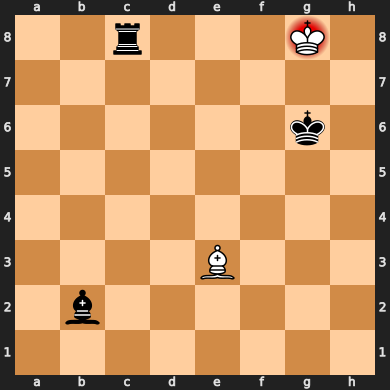

In [53]:
# env.decode(b'\x80\x03}q\x00(X\x05\x00\x00\x00boardq\x01}q\x02(K?cchess\nPiece\nq\x03)\x81q\x04}q\x05(X\n\x00\x00\x00piece_typeq\x06K\x04X\x05\x00\x00\x00colorq\x07\x89ubK=h\x03)\x81q\x08}q\t(h\x06K\x03h\x07\x89ubK<h\x03)\x81q\n}q\x0b(h\x06K\x06h\x07\x89ubK:h\x03)\x81q\x0c}q\r(h\x06K\x03h\x07\x89ubK8h\x03)\x81q\x0e}q\x0f(h\x06K\x04h\x07\x89ubK6h\x03)\x81q\x10}q\x11(h\x06K\x01h\x07\x89ubK4h\x03)\x81q\x12}q\x13(h\x06K\x01h\x07\x89ubK3h\x03)\x81q\x14}q\x15(h\x06K\x01h\x07\x89ubK1h\x03)\x81q\x16}q\x17(h\x06K\x01h\x07\x89ubK0h\x03)\x81q\x18}q\x19(h\x06K\x01h\x07\x89ubK/h\x03)\x81q\x1a}q\x1b(h\x06K\x01h\x07\x89ubK*h\x03)\x81q\x1c}q\x1d(h\x06K\x01h\x07\x89ubK(h\x03)\x81q\x1e}q\x1f(h\x06K\x02h\x07\x89ubK#h\x03)\x81q }q!(h\x06K\x02h\x07\x89ubK!h\x03)\x81q"}q#(h\x06K\x03h\x07\x88ubK\x1dh\x03)\x81q$}q%(h\x06K\x01h\x07\x88ubK\x1bh\x03)\x81q&}q\'(h\x06K\x01h\x07\x88ubK\x17h\x03)\x81q(}q)(h\x06K\x01h\x07\x88ubK\x16h\x03)\x81q*}q+(h\x06K\x01h\x07\x88ubK\x15h\x03)\x81q,}q-(h\x06K\x01h\x07\x89ubK\x12h\x03)\x81q.}q/(h\x06K\x01h\x07\x88ubK\x11h\x03)\x81q0}q1(h\x06K\x01h\x07\x88ubK\x10h\x03)\x81q2}q3(h\x06K\x05h\x07\x89ubK\x07h\x03)\x81q4}q5(h\x06K\x04h\x07\x88ubK\x06h\x03)\x81q6}q7(h\x06K\x02h\x07\x88ubK\x04h\x03)\x81q8}q9(h\x06K\x06h\x07\x88ubK\x02h\x03)\x81q:}q;(h\x06K\x03h\x07\x88ubK\x01h\x03)\x81q<}q=(h\x06K\x02h\x07\x88ubK\x00h\x03)\x81q>}q?(h\x06K\x04h\x07\x88ubuX\x04\x00\x00\x00turnq@\x88X\r\x00\x00\x00legal_actionsqA]qB(X\x04\x00\x00\x00b5c6qCX\x04\x00\x00\x00b5a6qDX\x04\x00\x00\x00b5c4qEX\x04\x00\x00\x00b5a4qFX\x04\x00\x00\x00b5d3qGX\x04\x00\x00\x00b5e2qHX\x04\x00\x00\x00b5f1qIX\x04\x00\x00\x00h1h2qJX\x04\x00\x00\x00g1f3qKX\x04\x00\x00\x00g1e2qLX\x04\x00\x00\x00e1f2qMX\x04\x00\x00\x00e1d2qNX\x04\x00\x00\x00e1f1qOX\x04\x00\x00\x00e1d1qPX\x04\x00\x00\x00c1e3qQX\x04\x00\x00\x00c1a3qRX\x04\x00\x00\x00c1d2qSX\x04\x00\x00\x00c1b2qTX\x04\x00\x00\x00b1a3qUX\x04\x00\x00\x00b1d2qVX\x04\x00\x00\x00a1a3qWX\x04\x00\x00\x00a1a2qXX\x04\x00\x00\x00f4f5qYX\x04\x00\x00\x00h3h4qZX\x04\x00\x00\x00g3g4q[X\x04\x00\x00\x00c3c4q\\X\x04\x00\x00\x00b3b4q]eu.')
# CURRENT MAIN BOARD
print("TERMINAL TEST", env.terminal_test(), env.result(), "WHITES TURN", env.whites_turn)
print(f"LEGAL ACTIONS\n{env.legal_actions()}")
env.board

RESULT *
BLACK TERMINAL TEST False 0 MCTS BLACKS TURN True
LEGAL ACTIONS
['d4e6', 'd4c6', 'd4f5', 'd4b5', 'd4f3', 'd4b3', 'd4c2', 'd3a6', 'd3f5', 'd3b5', 'd3e4', 'd3c4', 'd3h3', 'd3g3', 'd3f3', 'd3e3', 'd3c2', 'd3b1', 'a3b5', 'a3c4', 'a3c2', 'a3b1', 'h1g1', 'e1f2', 'e1d1', 'a1b1', 'c3b4', 'e5e6', 'c3c4', 'h2h3', 'g2g3', 'e2e3', 'b2b3', 'h2h4', 'g2g4', 'e2e4', 'e5d6']


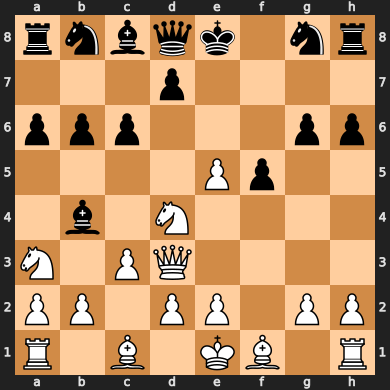

In [19]:
print("BLACK TERMINAL TEST", mcts_black.env.terminal_test(), mcts_black.env.result(), "MCTS BLACKS TURN", not mcts_black.env.whites_turn)
print(f"LEGAL ACTIONS\n{mcts_black.env.legal_actions()}")
mcts_black.env.board

RESULT *
WHITE TERMINAL TEST False 0 MCTS WHITE TURN True
LEGAL ACTIONS
['e2a6', 'e2h5', 'e2b5', 'e2g4', 'e2c4', 'e2f3', 'e2d3', 'e2f1', 'h1h2', 'g1f3', 'e1f2', 'e1f1', 'd1c2', 'c1b2', 'a1a2', 'f4f5', 'h3h4', 'g3g4', 'c3c4', 'b3b4', 'a3a4', 'd2d3', 'd2d4']


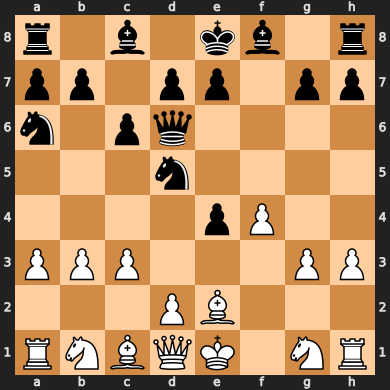

In [20]:
print("WHITE TERMINAL TEST", mcts_white.env.terminal_test(), mcts_white.env.result(), "MCTS WHITE TURN", mcts_white.env.whites_turn)
print(f"LEGAL ACTIONS\n{mcts_white.env.legal_actions()}")
mcts_white.env.board

True
RESULT *
TERMINAL TEST False 0 WHITE TURN False


False